# Modelo RAG (Retrieval Augmented Generation)
- Técnica utilizada para ampliar a capacidade de resposta de LLMs
- Combina o conhecimento interno do modelo com sistemas de recuperação de informações
- O modelo busca informações relevantes em base de dados externas como banco de dados ou até mesmo documentos
- Fases:
    - Coleta de dados
    - Agrupamento de dados
    - Incorporação de documentos
    - Tratamento de consultas de usuários
    - Geração de respostas com um LLM

In [ ]:
import torch
from datasets import load_dataset
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForCausalLM,
)
from sentence_transformers import SentenceTransformer
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)
import numpy as np
import random
from tqdm.auto import tqdm
import faiss

# Reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [ ]:
#Utilizando o dataset IMDb que contém comentários sobre os filmes e o rótulo de sentimento (1-> positivo e 0 -> negativo)

# ============================
# 3.1 Carregar dataset IMDb
# ============================
dataset = load_dataset("stanfordnlp/imdb")

# Subconjuntos para caber no Colab
N_TRAIN = 2000
N_TEST  = 200

train_data = dataset["train"].shuffle(seed=SEED).select(range(N_TRAIN))
test_data  = dataset["test"].shuffle(seed=SEED).select(range(N_TEST))

label_map = {0: "negative", 1: "positive"}

print("Exemplo de dado de treino:")
print(train_data[0])
print("Tamanhos -> train:", len(train_data), "| test:", len(test_data))

Exemplo de dado de treino:
{'text': 'There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...', 'label': 1}
Tamanhos -> train: 2000 | test: 200


In [ ]:
def add_label_prefix(example):
    label_text = label_map[example["label"]]
    example["text_with_label"] = f"SENTIMENTO: {label_text}\n{example['text']}"
    return example

train_data = train_data.map(add_label_prefix)

print(train_data[0]["text_with_label"])

Map: 100%|██████████| 200/200 [00:00<00:00, 16284.76 examples/s]

SENTIMENTO: positive
There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...


In [14]:
texts_train = train_data["text_with_label"]
texts_test = test_data["text"]

In [ ]:
print("--- 1. Criando Embeddings e Índice FAISS ---")

# Modelo Leve para Embeddings (Melhor para CPU e RAG)
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# 1. Gerar Embeddings para os Documentos
document_embeddings = embedding_model.encode(texts_train, convert_to_numpy=True)
dimension = document_embeddings.shape[1] # Dimensão do vetor (384 para MiniLM)

# 2. Construir o Índice FAISS
# IndexFlatL2 é o índice mais simples, baseado na distância euclidiana (L2)
# Utilizado para encontrar vetores mais parecidos entre si, e mais rapidamente
index = faiss.IndexFlatL2(dimension)
index.add(document_embeddings.astype('float32'))

print(f"Índice FAISS criado com {index.ntotal} documentos, dimensão: {dimension}")

--- 1. Criando Embeddings e Índice FAISS ---
Índice FAISS criado com 2000 documentos, dimensão: 384


In [ ]:
#Utilizando Modelo flan-t5-base pois ele é melhor para classificações (como o caso em estudo)
#Modelos como distilbert QA ou até mesmo GPT-2 não respondem bem para o exemplo
gen_pipeline = pipeline(
    "text2text-generation",
    model="google/flan-t5-base"
)

def run_rag_generate(query: str, k: int = 2):

    #Criando o embedding para a pergunta recebida
    query_embedding = embedding_model.encode([query], convert_to_numpy=True).astype("float32")
    distances, indices = index.search(query_embedding, k)
    #Passando os documentos para o RAG se basear
    retrieved_docs = [texts_train[i] for i in indices[0]]
    context = " ".join(retrieved_docs)

    # Definindo o prompt final para o modelo responder
    prompt = f"""
    Classify the sentiment of the text below as positive or negative.

    TEXT:
    {query}

    CONTEXT FROM RETRIEVAL:
    {context}

    Respond with only: positive or negative.
    """

    # Geração da resposta
    output = gen_pipeline(prompt)[0]["generated_text"]

    return output

Device set to use cpu


In [36]:
#Fazendo a comparação para cada dado de teste
preds = []
trues = list(test_data["label"])

for i, text in enumerate(texts_test):
    response = run_rag_generate(text, k=2)

    # Normalizar resposta
    r = response.lower().strip()

    if "positive" in r:
        pred = 1
    elif "negative" in r:
        pred = 0
    else:
        pred = 1 if "pos" in r else 0

    preds.append(pred)

    # Tratar texto fora do f-string
    preview = text[:120].replace("\n", " ")

accuracy = np.mean(np.array(preds) == np.array(trues))

print("\n==============================")
print(f"ACURÁCIA DO MODELO: {accuracy:.4f}")
print("==============================")


ACURÁCIA DO MODELO: 0.6850



Matriz de Confusão (valores brutos):
[[85 19]
 [44 52]]


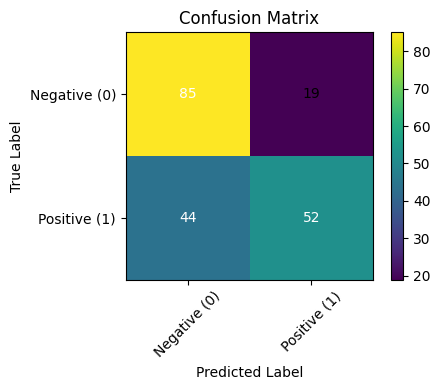

In [37]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(trues, preds)

print("\nMatriz de Confusão (valores brutos):")
print(cm)

# Plot opcional
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()

classes = ["Negative (0)", "Positive (1)"]
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Colocar números dentro dos quadrados
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i,j] > cm.max()/2 else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

In [38]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# ==========================================
#     MÉTRICAS DE AVALIAÇÃO COMPLETAS
# ==========================================

print("Accuracy:", accuracy_score(trues, preds))
print("Precision:", precision_score(trues, preds))
print("Recall:", recall_score(trues, preds))
print("F1-score:", f1_score(trues, preds))

print("\n--- Classification Report ---")
print(classification_report(trues, preds, target_names=["negative", "positive"]))

Accuracy: 0.685
Precision: 0.7323943661971831
Recall: 0.5416666666666666
F1-score: 0.6227544910179641

--- Classification Report ---
              precision    recall  f1-score   support

    negative       0.66      0.82      0.73       104
    positive       0.73      0.54      0.62        96

    accuracy                           0.69       200
   macro avg       0.70      0.68      0.68       200
weighted avg       0.69      0.69      0.68       200

